# More advanced applications

In this notebook, we show a few applications as a showcase of the interface and of additional helper functions.

Before starting, make sure that you are already familiar with manipulating [trajectories](1_trajectory.html), [workflows](2_workflow.html) and [descriptors](3_descriptors.html).

## Interchangibility of the descriptors

Say we performed a clustering on a system using a given structural descriptor, *e.g.* using bond-angles (`BondAngleDescriptor`):

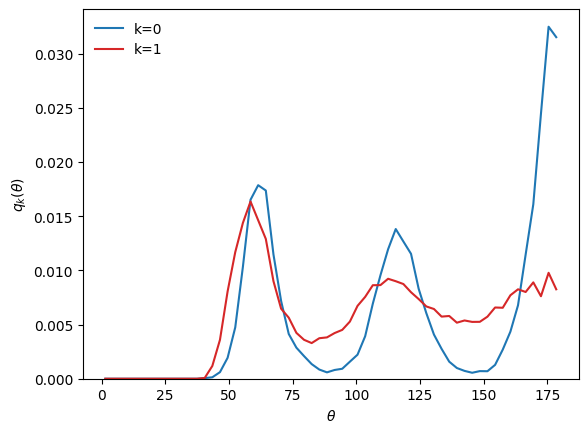

In [1]:
from partycls import Trajectory, Workflow
from partycls.descriptors import BondAngleDescriptor
import matplotlib.pyplot as plt

# Trajectory
traj = Trajectory('data/wahn_N1000.xyz')

# Bond-angle descriptor
D_ba = BondAngleDescriptor(traj)
D_ba.add_filter("species == 'B'", group=0)

# Workflow
wf = Workflow(traj,
              descriptor=D_ba,
              scaling='zscore',
              clustering='kmeans')
wf.clustering.n_init = 100
wf.run()

# Plot the centroids
theta = D_ba.grid
Ck = wf.clustering.centroids(wf.features)
q0 = D_ba.normalize(Ck[0], method='pdf')
q1 = D_ba.normalize(Ck[1], method='pdf')

plt.plot(theta, q0, c='tab:blue', label='k=0')
plt.plot(theta, q1, c='tab:red', label='k=1')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$q_k(\theta)$')
plt.ylim(bottom=0)
plt.legend(frameon=False)
plt.show()

Now, we want to see the $g(r)$ of the clusters, despite the fact that the clustering was performed using the bond-angle descriptor.

We only need to compute the radial descriptor, and then we can directly use the labels from the previous clustering to look at the corresponding radial distributions: 

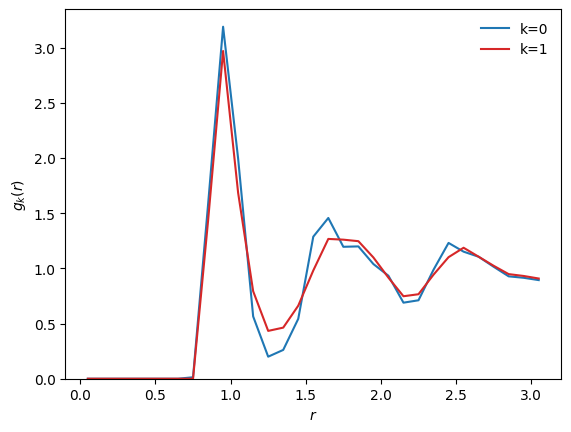

In [2]:
from partycls.descriptors import RadialDescriptor

# Compute the radial descriptor
D_r = RadialDescriptor(traj)
D_r.add_filter("species == 'B'", group=0)
X_r = D_r.compute()

# Plot the corresponding radial centroids
#  using an external dataset for the centroids
r = D_r.grid
Ck = wf.clustering.centroids(X_r)
g0 = D_r.normalize(Ck[0], method='gr')
g1 = D_r.normalize(Ck[1], method='gr')

plt.plot(r, g0, c='tab:blue', label='k=0')
plt.plot(r, g1, c='tab:red', label='k=1')
plt.xlabel(r'$r$')
plt.ylabel(r'$g_k(r)$')
plt.ylim(bottom=0)
plt.legend(frameon=False)
plt.show()

The result of a clustering performed using any arbitrary descriptor can thus be visualized using any other dataset (including datatsets on which feature scaling or dimensionality reduction were performed). Cluster labels are fully independent from the notion of descriptor, making the `centroids()` method very flexible.

<div class="alert alert-warning">
    Important
    
    Both descriptors should have the **same filters** applied in order to perform this mapping between them.
</div>

## Identification of structural heterogeneity without clustering

The `Workflow` class is useful when we already know the sequence of steps to follow when performing a clustering. However, when studying the local structure of a system in a broader context, some aspects can become apparent without the need for a clustering.

Here, we compute a bond-orientational descriptor variant introduced by [Lechner and Dellago](https://aip.scitation.org/doi/10.1063/1.2977970) (`LocallyAveragedBondOrientationalDescriptor` or its alias `LechnerDellagoDescriptor`) on a partially crystallized binary mixture, then perform a dimensionality reduction and look at the structural features in the reduced feature space:

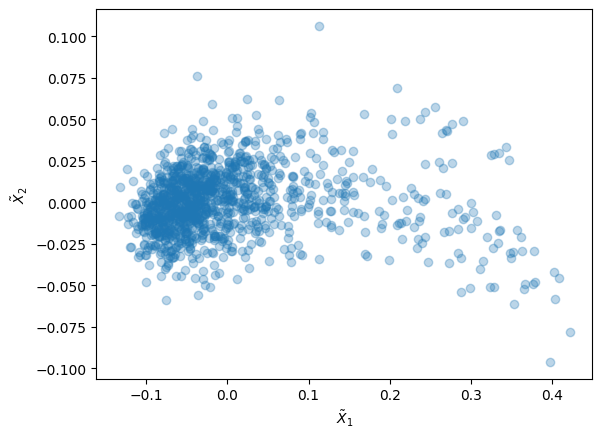

In [3]:
from partycls.descriptors import LechnerDellagoDescriptor
from partycls import PCA

# Open the trajectory
traj = Trajectory('data/kalj_fcc_N1200.xyz')

# Compute the descriptor
D_ld = LechnerDellagoDescriptor(traj)
X = D_ld.compute()

# Dimensionality reduction with PCA
redux = PCA(n_components=2)
X_red = redux.reduce(X)

# Show reduced feature space
plt.scatter(X_red[:,0], X_red[:,1], alpha=0.3)
plt.xlabel(r'$\tilde{X}_1$')
plt.ylabel(r'$\tilde{X}_2$')
plt.show()

We see in the reduced feature space that the majority of the particles are concentred on the left, while some outliers are present on the right. Without even the need for a clustering, we want to see how different these particles on the right are from the bulk. For that, we decide that each particle with reduced feature $\tilde{X}_1 > 0.18$ is somehow **special**.

Using the notion of *groups* (see the notebook on [descriptors](3_descriptors.html)),let us give an arbitrary particle property `special` to all the particles: 0 if not special, 1 if special:

In [4]:
# Select outliers based on their first reduced feature
threshold = 0.18
outliers = []
for xn, x in enumerate(X_red):
    if x[0] > threshold:
        outliers.append(xn)

# Set a particle property `special` to 0 or 1
#  by iterating over the group 0 of the descriptor
#  (i.e.) all the particles for which the descriptor was computed
traj[0].set_property('special', 0) # set special=0 to all particles first
for pn, p in enumerate(D_ld.groups[0][0]): # now special=1 to the selected ones
    if pn in outliers:
        p.special = 1

Now, in order to be able to visualize these particles in a snapshot, let us set a small value for the `radius` of all the particles that are not special, and a regular radius for the special ones:

In [5]:
traj[0].set_property('radius', 0.1, 'particle.special == 0')
traj[0].set_property('radius', 0.5, 'particle.special == 1')

We can now visualize the particles in real space and see why these outliers stand out:

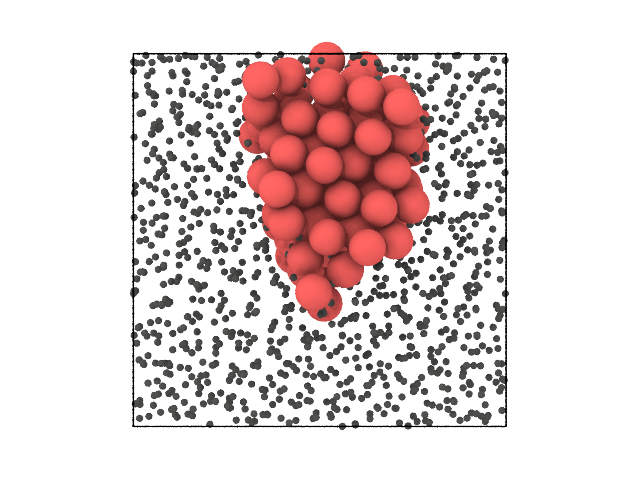

In [6]:
traj[0].show(backend='ovito', color='special', view='left')

It turns out that the outliers form a small FCC crystal. We were able to see that something was different in their local structure solely based on their position in the reduced feature space, and did not have to apply a clustering to do so.

## Aggregation of clusters

When performing a clustering with model-based methods, such as the [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html) (GMM) which consists in fitting a given number of multivariate Gaussian distributions to the data, it can happen that the original distribution is poorly fitted by the by various components. Or we could be unsure about the right number of components to use to fit the original distribution.

Let us come back to the previous example, on which we will perform a clustering using GMM with more components than needed:

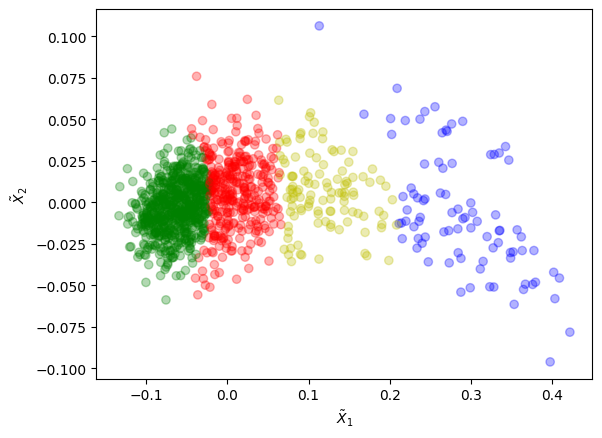

In [7]:
from partycls import GaussianMixture
import numpy as np

# Perform a clustering on the reduced feature space
# of the previous example
C = GaussianMixture(n_clusters=4, n_init=50)
C.fit(X_red)
labels = C.labels

# Plot the clusters in reduced feature space using
#  a *hard* clustering
clrs = np.array(['r', 'b', 'g', 'y'])
plt.scatter(X_red[:,0], X_red[:,1], c=clrs[labels], alpha=0.3)
plt.xlabel(r'$\tilde{X}_1$')
plt.ylabel(r'$\tilde{X}_2$')
plt.show()

Here, we are basically cutting slices through a distribution that could be approximated well enough with only two Gaussians.

Let us use an aggregation method (see [Baudry et al.](https://doi.org/10.1198/jcgs.2010.08111)) to merge these 4 clusters into 2 by combining the components of GMM:

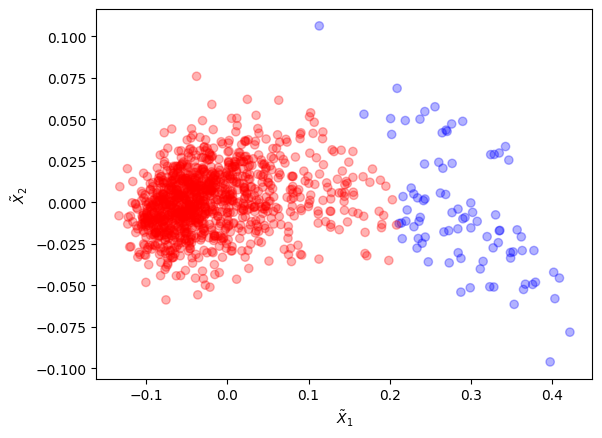

In [8]:
from partycls.helpers import merge_clusters

# Use weights from GMM to merge the clusters into `n_cluster_min`
# This returns new weights and new labels
weights = C.backend.predict_proba(X_red)
new_weights, new_labels = merge_clusters(weights, n_clusters_min=2)

# Plot clusters with new labels
plt.scatter(X_red[:,0], X_red[:,1], c=clrs[new_labels], alpha=0.3)
plt.xlabel(r'$\tilde{X}_1$')
plt.ylabel(r'$\tilde{X}_2$')
plt.show()

The old clusters were merged into 2 new clusters that form a better partitioning.